In [1]:
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from polynomialcurve import PolynomialPointCurve
import LaplacianEigenmaps

Using TensorFlow backend.
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/neha/.local/lib/python3.6/site-packages/tensorflow/python/framewo

##  Generate data #######################

The dataset is 2000 random samples from a closed curve in 3D: 

$x_i = \left( \cos(\theta_i), \sin(2\theta_i) , \sin(3\theta_i)\right)^T, \;\;\; \theta_i \in (0,2\pi).    $

In [2]:
# n = 3000
# t = 2.01*np.pi*np.random.uniform(0,1,n)
# x = np.cos(t)
# y = np.sin(2*t)
# z = np.sin(3*t)
# orig_data = np.vstack([x,y,z])
# orig_data = np.transpose(orig_data)

# # add noise
# noise_std = 0.05
# data = orig_data + noise_std*np.random.randn(orig_data.shape[0],orig_data.shape[1])

# n_train = 2000
# n_test = n - n_train

# S1_train   = data[:n_train,:]
# S1_test    = data[n_train+1:,:]
# t_train    = t[:n_train]
# t_test     = t[n_train+1:]
# input_size = S1_train.shape[1]
# batch_size = S1_train.shape[0]

# sort_inds = np.argsort(t_train)

In [3]:
# fig, (a1)  = plt.subplots(1,1, subplot_kw={'projection':'3d'})
# a1.scatter(S1_train[:,0], S1_train[:,1], S1_train[:,2], c=t_train, cmap='gist_ncar')
# plt.title('training data')
# plt.show()

The diffusion map of a closed curve is a 2D circle.

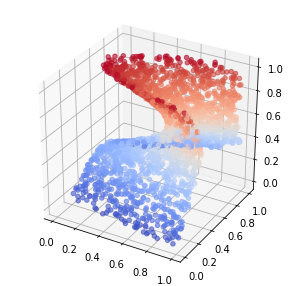

In [4]:
polycurve = PolynomialPointCurve(seed=3141, dimension=3, avg_dims_per_term=1, avg_power_per_dim=2, num_terms=3, avg_mono_term_power=1, max_coeff=2)
#3141 is a good seed
polycurve.compute_threshold(.05)
data = polycurve.gen_noisy_points(3000)
fig=plt.figure(figsize=(5,5))
a1=fig.add_subplot(111, projection='3d')
a1.scatter(data[:,0], data[:,1], data[:,2], c = data[:,2], cmap='coolwarm', alpha=.6)
plt.show()

In [5]:
data = polycurve.gen_noisy_points(3000)
T_THRESH = 2000
S1_train = data[:T_THRESH]
test = data[T_THRESH:]

In [6]:
nearest_neighbors = 'knn'
k=16
embedding_size = 2
n_paths = 5
hidden_dim  = 40

In [7]:
Idx, Dx = df.Knnsearch(S1_train, S1_train, k)
print(Dx.shape)
K_mat = df.ComputeLBAffinity(Idx, Dx, sig=0.1)  # Laplace-Beltrami affinity: D^-1 * K * D^-1
P = df.makeRowStoch(K_mat)  # markov matrix
E, v = df.Diffusion(K_mat, nEigenVals=embedding_size + 1)  # eigenvalues and eigenvectors
embedding_matrix = P

(2000, 16)


In [8]:
S1_train.shape

(2000, 3)

In [9]:
diffusion_weights =  [tf.cast(tf.constant(np.power(v, i+1)), tf.float32) for i in range(n_paths)]
E_casted = tf.cast(tf.constant(E), tf.float32)

In [10]:
summed = diffusion_weights[0]
for i in range(n_paths -1):
    summed = summed + diffusion_weights[1]
print(summed)

def sum_list_of_tensors(lst, length):
    summed = lst[0]
    for i in range(length - 1):
        summed = summed + diffusion_weights[i+1]
    return summed

Tensor("add_3:0", shape=(2,), dtype=float32)


In [11]:
input_size = S1_train.shape[1]
batch_size = S1_train.shape[0]
E_W1 = tf.Variable(tf.random_normal([input_size, hidden_dim]))
E_b1 = tf.Variable(tf.random_normal([hidden_dim]))
E_W2 = tf.Variable(tf.random_normal([hidden_dim, 1]))
E_b2 = tf.Variable(tf.random_normal([1]))
E_W3 = tf.Variable(tf.random_normal([n_paths, batch_size]))
D_W1 = tf.Variable(tf.random_normal([embedding_size, hidden_dim]))
D_b1 = tf.Variable(tf.random_normal([hidden_dim]))
D_W2 = tf.Variable(tf.random_normal([hidden_dim, input_size]))

## 

In [12]:
def neha_autoencoder(x):
    h1 = tf.nn.sigmoid(tf.matmul(x, E_W1) + E_b1)
    h2 = tf.nn.sigmoid(tf.matmul(h1, E_W2) + E_b2)
    alphas = tf.matmul(tf.abs(E_W3), tf.abs(h2))
    weighted_vals = [tf.multiply(alphas[i], diffusion_weights[i]) for i in range(n_paths)]
    total_weighting = sum_list_of_tensors(weighted_vals, n_paths)
    diag_weight = tf.diag(total_weighting)
    emb = tf.matmul(E_casted, diag_weight)
    d1 = tf.nn.sigmoid(tf.matmul(emb, D_W1) + D_b1)
    out = tf.matmul(d1, D_W2)
    return out, alphas

In [13]:
reg_par = 1e-4
learning_rate = 1e-2
n_iters = 12000
parameters = [E_W1, E_W2, E_W3, D_W1, D_W2, E_b1, E_b2, D_b1]
X = tf.placeholder(tf.float32, shape=[batch_size, input_size])
R, A = neha_autoencoder(X)

In [14]:
a_reg = tf.nn.l2_loss(D_W2)
a_loss = tf.reduce_mean(tf.square(X - R)) + reg_par * a_reg
solver = (tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(a_loss, var_list=parameters))
sess = tf.Session()
sess.run(tf.global_variables_initializer())

step 0, loss 6.58e+00
[[174.6959 ]
 [176.0242 ]
 [176.9749 ]
 [175.1951 ]
 [175.68604]]


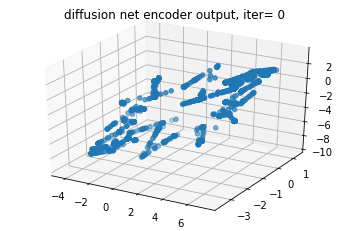

step 1500, loss 6.93e-02
[[0.00898689]
 [0.01335203]
 [0.01376848]
 [0.01320851]
 [0.01314518]]


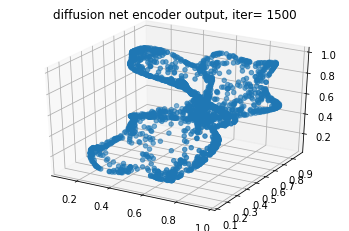

step 3000, loss 4.75e-02
[[0.00708079]
 [0.01067089]
 [0.01101257]
 [0.01055458]
 [0.01049868]]


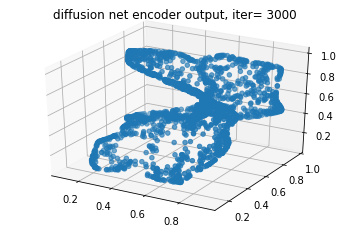

step 4500, loss 4.05e-02
[[0.0063392 ]
 [0.00961896]
 [0.00992982]
 [0.00951384]
 [0.00946438]]


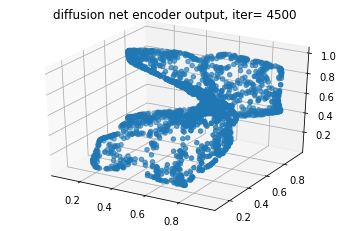

step 6000, loss 3.64e-02
[[0.0060436 ]
 [0.00919792]
 [0.00949647]
 [0.0090973 ]
 [0.00904545]]


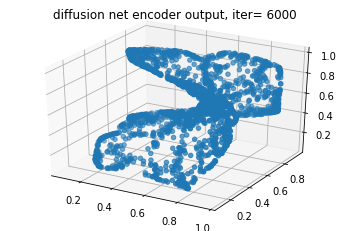

step 7500, loss 3.51e-02
[[0.00581559]
 [0.00887005]
 [0.00915805]
 [0.00877204]
 [0.00872274]]


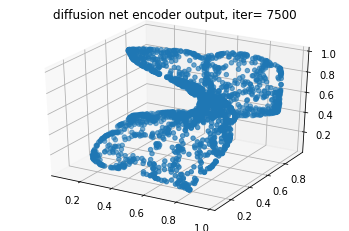

step 9000, loss 3.29e-02
[[0.00667543]
 [0.01007618]
 [0.01040232]
 [0.009968  ]
 [0.00991306]]


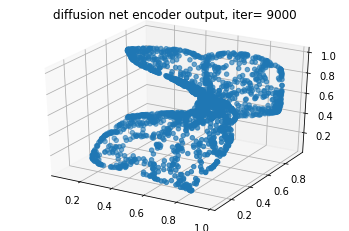

step 10500, loss 3.12e-02
[[0.00984009]
 [0.01445318]
 [0.01490388]
 [0.01430222]
 [0.01423222]]


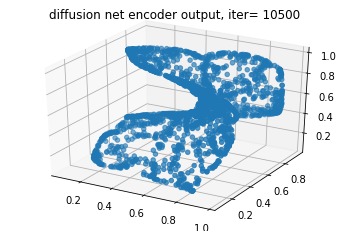

step 12000, loss 3.14e-02
[[0.03628454]
 [0.04951781]
 [0.05088329]
 [0.0490393 ]
 [0.04888101]]


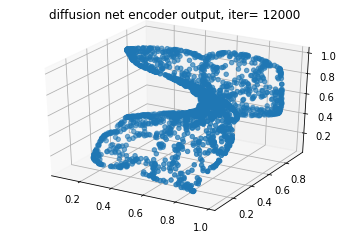

In [15]:
for i in range(n_iters+1):
    if i % 1500 == 0:  # plot intermediate outputs
        r, al = sess.run((R,A), feed_dict={X: S1_train})
        loss = np.mean(np.sum(np.abs(S1_train - r) ** 2, axis=1) ** (1. / 2))
        print('step %.d, loss %.2e' % (i, loss))
        print(al)
        fig, (a2) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
        a2.scatter(r[:, 0], r[:, 1], r[:,2])
        plt.axis('auto')
        plt.title('diffusion net encoder output, iter= ' + str(i))
        plt.show()
    _ = sess.run(solver, feed_dict={X:S1_train})
        
    

In [ ]:
sess.close()